<a href="https://colab.research.google.com/github/syphaxAouadene/Cours_programmation_concurrente/blob/main/my_first_CNN_for_handwritten_digit_classification_version_6_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import time
from IPython.display import clear_output
import json
import matplotlib.pyplot as plt
%pylab inline
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
from mlxtend.data import loadlocal_mnist
import platform

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# CNN operations

In [32]:
def multiplication(imaget, f):
    if len(imaget.shape) == 1 :
        imaget = imaget.reshape((imaget.shape[0], 1))
    result = imaget * f
    somme = 0
    for i in range(imaget.shape[0]):
        for j in range(imaget.shape[1]):
            somme = somme + result[i, j]
    return somme

# from scipy import signal
# def convolution(img, f):
#     return signal.convolve2d(img, f, mode='valid')

def convolution(img, f):
    result = np.zeros((img.shape[0] - f.shape[0] + 1, img.shape[1] - f.shape[1] + 1))
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            imaget = img[i:f.shape[0]+i, j:f.shape[1]+j]
            multi = multiplication(imaget, f)
            result[i, j] = multi
    return result


def ReLU_convolution(convolved_map):
    result = np.zeros(convolved_map.shape)
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            result[i, j] = np.max([convolved_map[i,j], 0])
    return result


def get_convolved_layer_from_previous_layer(previous_layer, nbr_filter, size_filter):
    """
    don't forget to add bias term corresponding to each filter !
    - previous_layer = is a list that contains each feature map of the previous_layer
    - nbr_filter = is an integer that represents how many filter do we want to use, (ex. 6)
    - size_filter = is an integer that represents the shape of each filter (if size_filter=3 then shape_filter=(3, 3))
    
    this function return a list that contains each convolved map 
    (you should know that convolved_map = convolution between feature_map and filter)
    """
    convolved_layer = []
    # filters = [initialize_filter(size_filter, size_filter) for i in range(nbr_filter)]
    # biais = initialize_filter(nbr_filter, 1)
    for f in filters:
        somme = 0
        bias = 0
        for feature_map in previous_layer:
            somme = somme + convolution(feature_map, f)
        somme = somme + bias
        convolved_layer.append(ReLU_convolution(somme))
    return convolved_layer, filters, biais


def max_pooling(convolved_map, size_of_pooling_kernel, stride):
#     result_of_pooling has to have shape = ((input_width - kernel_width + 2*padding)/stride) + 1
    result = np.zeros((int((convolved_map.shape[0]-size_of_pooling_kernel)/stride)+1, int((convolved_map.shape[0]-size_of_pooling_kernel)/stride)+1))
    for i in range(0, result.shape[0]):
        for j in range(0, result.shape[1]):
            imaget = convolved_map[stride*i:size_of_pooling_kernel+stride*i, stride*j:size_of_pooling_kernel+stride*j]
            result[i, j] = np.max(imaget)
    # print('------------------------')
    # print(result.shape)
    # print('------------------------')
    return result


def mean_pooling(convolved_map, size_of_pooling_kernel, stride):
    #     result_of_pooling has to have shape = ((input_width - kernel_width) + 2*padding/stride) + 1
    result = np.zeros((int((convolved_map.shape[0]-size_of_pooling_kernel)/stride)+1, int((convolved_map.shape[0]-size_of_pooling_kernel)/stride)+1))
    for i in range(0, result.shape[0], stride):
        for j in range(0, result.shape[1], stride):
            imaget = convolved_map[stride*i:size_of_pooling_kernel+stride*i, stride*j:size_of_pooling_kernel+stride*j]
            result[i, j] = np.mean(imaget)
    return result
    
    
def min_pooling(convolved_map, size_of_pooling_kernel, stride):
    #     result_of_pooling has to have shape = ((input_width - kernel_width) + 2*padding/stride) + 1
    result = np.zeros((int((convolved_map.shape[0]-size_of_pooling_kernel)/stride)+1, int((convolved_map.shape[0]-size_of_pooling_kernel)/stride)+1))
    for i in range(0, result.shape[0], stride):
        for j in range(0, result.shape[1], stride):
            imaget = convolved_map[stride*i:size_of_pooling_kernel+stride*i, stride*j:size_of_pooling_kernel+stride*j]
            result[i, j] = np.min(imaget)
    return result


def pooling(convolved_layer, type_of_pooling, size_of_pooling_kernel, stride):
    """
    convolved_layer : is a list that contains each convolved_map from previous_layer
    type_of_pooling : should be either 'MAX_POOLING' or 'MEAN_POOLING' or 'MIN_POOLING'
    size_of_pooling_kernel : is an integer that represents the shape of kernel 
                            (if size_of_pooling_kernel=2 then shape_kernel=(2, 2))
    this function return a list that contains each pooled_map
    """
    pooled_layer = []
    switcher = {
        'MAX_POOLING': max_pooling,
        'MEAN_POOLING': mean_pooling,
        'MIN_POOLING': min_pooling
    }
    # Get the function from switcher dictionary
    pooling_operation = switcher.get(type_of_pooling, lambda: "Invalid type_of_pooling !")
    # Execute the function
    for convolved_map in convolved_layer:
        pooled_layer.append(pooling_operation(convolved_map, size_of_pooling_kernel, stride))
    return pooled_layer


def initialize_filter(filter_width, filter_height):
    """
    cette fonction s'occupe de l'initialisation d'un filtre aléatoirement selon la distribution normale
    """
    return np.random.randn(filter_width, filter_height)


# def show_image(img):
#     plt.imshow(img, cmap=plt.cm.binary)
#     plt.show()
    
    
def show_multiple_images(images, nbr_of_images=5):
    for img in images[:nbr_of_images]:
        show_image(img)
        time.sleep(1)
        clear_output(wait=True)
        
        
# def flatten(layer):
#     """
#     #arguments:
#     layer : is a list of feature_maps
#     #returns : list of all numbers that contained in the feature maps in the layer
#     """
#     result = []
#     for matrix in layer:
#         result = result + list(matrix.flatten())
#     result = np.array(result).reshape((1, len(result)))
#     return result

# def fully_connected_layer(input_layer, nbr_neurons, activation_function='ReLU'):
#     current_layer = []
#     input_layer = np.array(input_layer)
#     for i in range(nbr_neurons):
#         bias = 0
#         weights = np.random.randn(len(input_layer), 1)
#         current_layer.append(np.max([multiplication(input_layer, weights) + bias, 0]))
#     return current_layer


# def softmax(data):
#     output = []
#     for value in data:
#         proba_value = np.exp(value)/(np.sum(np.exp(data)))
#         output.append(proba_value)
#     return output
        
# def categoricalCrossEntropy(generated_values, target_values):
#     somme = 0
#     for i in range(len(generated_values)):
#         somme = somme + target_values[i] * np.log(generated_values[i])
#     return (-1) * somme  

#######################################################################################
#######  Fully_connected_layer_functions
#######################################################################################

# def update_weights(dL_dY, weights, inputs, lrate):
#     """
#     arguments :
#     dL_dY : un vecteur des dérivées de la couche supérieure par rapport a la couche de sortie Y de dimension n_outputs
#     weights : la matrice des poids de dimension (n_inputs x n_outputs)
#     inputs : le vecteur de sortie de la couche précedente de dimension n_inputs
#     lrate : learning rate (scalar)
#     """
#     dL_dW = []
#     for xi in inputs:
#         dL_dW = dL_dW + xi * dL_dY
#     new_weights = flatten(weights) - lrate * dL_dW
#     new_weights = new_weights.reshape(weights.shape)
#     return new_weights

# def calcul_dL_dX(dL_dY, weights):
#     return np.dot(dL_dY, np.transpose(weights))


# def fcl(inputs_layer, nbr_neurons, weights, biais, activation_type='ReLU'):
#     current_layer = []
#     current_layer = flatten(np.dot(inputs_layer, weights) + biais)[0]
#     output_layer = activation_function(current_layer, activation_type)
#     return output_layer
   
# def activation_function(layer, type_of_activation='relu'):
#     type_of_activation = type_of_activation.lower()
#     switcher = {
#         'relu': ReLU,
#         'tanh': tanh,
#         'segmoid': segmoid
#     }
#     # Get the function from switcher dictionary
#     activation_type = switcher.get(type_of_activation, lambda: "Invalid type_of_activation_function, please choose either 'ReLU' or 'tanh' or 'segmoid' !")
#     return activation_type(layer)
    
    
# def ReLU(layer):
#     layer = np.array(layer)
#     result = []
#     for y in layer:
#         result.append(np.max([y, 0]))
#     return result

# def tanh(layer):
#     layer = np.array(layer)
#     result = []
#     for y in layer:
#         r = (np.exp(y)-np.exp(-1*y))/(np.exp(y)+np.exp(-1*y))
#         result.append(r)
#     return result

# def segmoid(layer):
#     layer = np.array(layer)
#     result = []
#     for y in layer:
#         r = 1/(1+np.exp(-1*y))
#         result.append(r)
#     return result

def back_error_from_end_to_output_fcl(y_hat, y):
    """
    arguments : y_hat = list des outputs calculés par le forward, et y = list des targets
    cette fonction va calculer l'erreur de son origine(end_of_network) jusqu'à le output de fully_connected_layer
    soit ce bout de network :
    X ---> softmax(X) ---> CCE(y_hat, y) ---> Loss
    alors cette fonction va retourner la dérivée de l'erreur Loss par rapport à X
    càd elle return dL_dX
    """
    return y_hat - y


def unflatten(vector, pooled_layer):
    pooled_layer = np.array(pooled_layer)
    vector = np.array(vector)
    # print(len(vector))
    vector = vector.reshape(pooled_layer.shape)
    return vector
        
        

# Fully Connected Layer Operations

In [5]:
def activation_function(layer, type_of_activation='relu'):
    type_of_activation = type_of_activation.lower()
    switcher = {
        'relu': ReLU,
        'tanh': tanh,
        'segmoid': segmoid
    }
    # Get the function from switcher dictionary
    activation_type = switcher.get(type_of_activation, lambda: "Invalid type_of_activation_function, please choose either 'ReLU' or 'tanh' or 'segmoid' !")
    return activation_type(layer)
    

def ReLU(layer):
    return layer * (layer > 0)


def d_ReLU(layer):
    return 1. * (layer > 0)


def tanh(layer):
    print('tanh')
    r = (np.exp(layer)-np.exp(-1*layer))/(np.exp(layer)+np.exp(-1*layer))   
    return np.array(r)


def d_tanh(layer):
    return 1 - tanh(layer) * tanh(layer)


def segmoid(layer):
    # print('segmoid')
    return np.array(1/(1+np.exp(-1*layer)))


def d_segmoid(vector):
    """
    cette fontion prend un vector en entrée et retourne la dérivée de segmoid par rapport a ce vector
    """
    return segmoid(vector) * (1 - segmoid(vector))


# def softmax(data):
#     # print('softmax')
#     # print(data)
#     proba_values = np.exp(data)/(np.sum(np.exp(data)))   
#     return np.array(proba_values)

def softmax(x):
    maxi = np.max(x)
    return np.exp(x-maxi)/sum(np.exp(x-maxi))


def categoricalCrossEntropy(generated_values, target_values):
    generated_values = [[1.0e-100] if r[0]==0.0 else r for r in generated_values]
    somme = 0
    for i in range(len(generated_values)):
        somme = somme + target_values[i] * np.log(generated_values[i])
    return (-1) * somme 


def normelize(img):
    return img/255


def flatten(img):
    img = np.array(img) 
    return img.flatten()


def show_image(img):
    plt.imshow(img, cmap=plt.cm.binary)
    plt.show()
    

def init_params(my_network):
    nbr_layers = len(my_network) - 1
    W, B = [], []
    for i in range(nbr_layers):
        W.append(np.random.randn(my_network[i+1], my_network[i]))
        B.append(np.random.randn(my_network[i+1], 1))
    return W, B


def forward_pass(img, W, B):
    """
    here we will use this notation :
    Z[i] = W[i].X + B[i]
    A[i] = activation_function(Z[i])
    Z is a list that carries all the output of each layer
    A is a list that carries all the output of each activation function
    """
    act_functions = activation_functions_fcl[1:-1] # we omit the first element and the last one because the first activation will be None, and the last one will always be 'softmax'
    act_functions = [type_of_activation.lower() for type_of_activation in act_functions] # lawercase all the items
    switcher = {
        'relu': ReLU,
        'tanh': tanh,
        'segmoid': segmoid
    }
    # Get the function from switcher dictionary
    activation_types = [switcher.get(type_of_activation, lambda: "Invalid type_of_activation_function") for type_of_activation in act_functions]
    Z, A = [], [img]
    for i in range(len(W)):
        if i == len(W)-1: # we have to use softmax as activation layer because we're in the last layer
            Z.append(np.dot(W[i], A[i]) + B[i])
            A.append(softmax(Z[i]))
        else: # we're in hidden layer
            Z.append(np.dot(W[i], A[i]) + B[i])
            A.append(activation_types[i](Z[i]))
    return Z, A


def one_hot(y):
    return np.eye(10)[y].reshape(10, 1)


def update_W_and_B(W, dL_dW, B, dL_dB, lr):
    """
    this function update the weights and Biais of myNetwork
    arguments : 
    - W : it is a list that contains each Weight vector ([W1, W2, ...])
    - dL_dW : derivatives of loss with respect to Weights (it is a list that contains Weights derivatives vectors [dL_dW1, dL_dW2, ...])
    - B : it is a list that contains each Biais vector ([B1, B2, ...])
    - dL_dB : derivatives of loss with respect to Biais (it is a list that contains Biais derivatives vectors [dL_dB1, dL_dB2, ...])
    - lr : learning rate (real number)
    """
    # print('Update_W_and_B')
    new_W = []
    new_B = []
    
    for w, dw in zip(W, dL_dW):
        try:
            w = np.array(w) - lr * np.array(dw)
        except:
            w = None
        
        new_W.append(w)
    for b, db in zip(B, dL_dB):
        try:
            b = np.array(b) - lr * np.array(db)
        except:
            b = None
        
        new_B.append(b)
        
    return new_W, new_B


def compute_accuracy(my_cnn, x_val, y_val, W, B):
    '''
        This function does a forward pass of x_validation, then checks if the indices
        of the maximum value in the output equals the indices in the label
        y. Then it sums over each prediction and calculates the accuracy.
    '''
    predictions = []

    for x, y in zip(x_val, y_val):
        # prepare the input image
        # X = flatten(x)
        # X = X.reshape(len(X), 1)
        Y = one_hot(y)
        # forward-propagation
        Z, A = forward_propagation([x], my_cnn, W, B)
        output = A[-1]
        pred = np.argmax(output)
        predictions.append(pred == np.argmax(Y))

    return np.mean(predictions)


def classify(img, W, B):
    """
    cette fonction recois une seule image en parametre
    et elle reçois les poids W et les Biais B et la liste des fonctions d'activations
    et elle retourne la catégorie de l'image en entier 0..9
    """
    predictions = []
    X = flatten(img)
    X = X.reshape(len(X), 1)
    # forward-propagation
    Z, A = forward_pass(X, W, B)
    output = A[-1]
    pred = np.argmax(output)
    return pred


def show_accuracies(my_cnn, train_images, train_labels, val_images, val_labels, test_images, test_labels, W, B):
    """
    this function compute accuracy for each train-set, validation-set, and test-set
    then print them all.
    arguments : train_images, train_labels, val_images, val_labels, test_images, test_labels, W, B
    """
    train_accuracy = compute_accuracy(my_cnn, train_images, train_labels, W, B)
    val_accuracy = compute_accuracy(my_cnn, val_images, val_labels, W, B)
    test_accuracy = compute_accuracy(my_cnn, test_images, test_labels, W, B)
    print("Accuracies :\n\
    - train accuracy = {} %\n\
    - val accuracy = {} %\n\
    - test accuracy = {} %".format(train_accuracy*100, val_accuracy*100, test_accuracy*100))


def backpro_pass(dL_dZ, A, Z, W, indice, indx_act_func):
    # we omit the first element and the last one because the first activation will be None, and the last one will always be 'softmax'
    act_functions = activation_functions[1:-1] 
    # lawercase all the items
    act_functions = [type_of_activation.lower() for type_of_activation in act_functions] 
    switcher = {
        'relu': d_ReLU,
        'tanh': d_tanh,
        'segmoid': d_segmoid
    }
    # Get the function from switcher dictionary
    activation_types = [switcher.get(type_of_activation, lambda: "Invalid type_of_activation_function") for type_of_activation in act_functions]
    
    dl_dw = np.dot(dL_dZ, np.transpose(A[indice]))
    dl_db = dL_dZ
    dl_dz = 0
    if indice*(-1) != len(Z)+1:
      dl_da = np.dot(np.transpose(W[indice+1]), dL_dZ)
      da_dz = activation_types[indx_act_func](Z[indice])
      dl_dz = dl_da * da_dz
    return dl_dw, dl_db, dl_dz

# Here we will upload the dataset and normelize it then shuffle it then split it

In [6]:
images_path = '/content/drive/MyDrive/Colab Notebooks/mnist_data/train-images.idx3-ubyte'
labels_path = '/content/drive/MyDrive/Colab Notebooks/mnist_data/train-labels.idx1-ubyte'
test_images_path = '/content/drive/MyDrive/Colab Notebooks/mnist_data/test-images.idx3-ubyte'
test_labels_path = '/content/drive/MyDrive/Colab Notebooks/mnist_data/test-labels.idx1-ubyte'
test_images, test_labels = loadlocal_mnist(test_images_path, test_labels_path)
train_images, train_labels = loadlocal_mnist(images_path, labels_path)

# group all the images in one list
# then normelize all the images
images = np.concatenate([train_images, test_images])
labels = np.concatenate([train_labels, test_labels])
images = normelize(images)

# shuffle all the images and all labels randomly
random.seed(12)
indices = np.arange(len(labels))
np.random.shuffle(indices)
labels = labels[indices]
images = images[indices]

# change shape of the images
images = images.reshape(len(images), 28, 28)

# split the data into train, validation and test 
train_images, val_images, test_images = images[:60000], images[60000:65000], images[65000:]
train_labels, val_labels, test_labels = labels[:60000], labels[60000:65000], labels[65000:]

# Learning  ------>  GO FOR LAUNCH !

In [7]:
def input_layer(dict):
  dict['type_of_layer'] = 'input'
  return dict

def convolution_layer(dict):
  dict['type_of_layer'] = 'convolution'
  return dict

def pooling_layer(dict):
  dict['type_of_layer'] = 'pooling'
  return dict

def flatten_layer():
  dict = {'type_of_layer': 'flatten'}
  return dict

def fcl(dict):
  dict['type_of_layer'] = 'fcl'
  return dict

In [22]:

my_cnn = [input_layer({
              'width_image': 28,
              'height_image': 28,
              'nbr_channels': 1   # 1 --> means gray scale, and 3 --> means rgb
              }
          ),
          convolution_layer({
              'nbr_of_kernels':6, 
              'kernel_size':5, 
              'padding':0, 
              'stride':1, 
              'type_of_activation':'relu'
              }
          ), 
          pooling_layer({
              'type_of_pooling' : 'MAX_POOLING',
              'kernel_size' : 2,
              'stride' : 2
              } 
          ),
          # convolution_layer({
          #     'nbr_of_kernels':6, 
          #     'kernel_size':5, 
          #     'padding':0, 
          #     'stride':1, 
          #     'type_of_activation':'relu'
          #     }
          # ), 
          # pooling_layer({
          #     'type_of_pooling' : 'MAX_POOLING',
          #     'kernel_size' : 5,
          #     'stride' : 2
          #     } 
          # ),
          flatten_layer(),
        #   fcl({
        #       'nbr_of_neurons' : 128, # 20 neurons in hidden layer
        #       'type_of_activation' : 'segmoid', # 'tanh' will be the activation function in the hidden layer, and 'softmax' in the last layer
        #       'learning_rate' : 0.001
        #         }
        #   ),
          fcl({
              'nbr_of_neurons' : 10, # nbr of neurons in output_layer layer
              'type_of_activation' : 'softmax', # 'tanh' will be the activation function in the hidden layer, and 'softmax' in the last layer
              'learning_rate' : 0.001
          }
          )
          ]
my_cnn

[{'height_image': 28,
  'nbr_channels': 1,
  'type_of_layer': 'input',
  'width_image': 28},
 {'kernel_size': 5,
  'nbr_of_kernels': 6,
  'padding': 0,
  'stride': 1,
  'type_of_activation': 'relu',
  'type_of_layer': 'convolution'},
 {'kernel_size': 2,
  'stride': 2,
  'type_of_layer': 'pooling',
  'type_of_pooling': 'MAX_POOLING'},
 {'type_of_layer': 'flatten'},
 {'learning_rate': 0.001,
  'nbr_of_neurons': 10,
  'type_of_activation': 'softmax',
  'type_of_layer': 'fcl'}]

In [10]:
def forward_propagation(img, my_cnn, W, B):
    my_cnn_architecture = [my_cnn[layer]['type_of_layer'] for layer in range(len(my_cnn))]
    switcher = {
        'convolution': convolution_operation,
        'pooling': pooling_operation,
        'flatten': flatten_operation,
        'fcl' : fcl_operation
    }
    # Get the function from switcher dictionary
    operation_types = [switcher.get(type_of_layer, lambda: "Invalid type_of_activation_function") for type_of_layer in my_cnn_architecture]
    Z, A = [img], [img]
    for i in range(1, len(my_cnn)):
        z, a = operation_types[i](my_cnn[i], A, W, B, i)
        Z.append(z)
        A.append(a)
    return Z, A

In [11]:
# def input_operation(layer, A, W, B, layer_num):
#     a = None
#     z = None
#     return a, z

def convolution_operation(layer, A, W, B, layer_num):
    previous_layer = A[-1]
    nbr_filters = layer['nbr_of_kernels']
    size_filter = layer['kernel_size']
    convolved_layer = []
    filters = W[layer_num]
    biais = B[layer_num]
    z = []
    for i in range(len(filters)):
        somme = 0
        for feature_map in previous_layer:
            somme = somme + convolution(feature_map, filters[i])
        somme = somme + biais[i]
        z.append(somme)
        convolved_layer.append(ReLU(somme))
    return z, convolved_layer

def pooling_operation(layer, A, W, B, layer_num):
    """
    convolved_layer : is a list that contains each convolved_map from previous_layer
    type_of_pooling : should be either 'MAX_POOLING' or 'MEAN_POOLING' or 'MIN_POOLING'
    size_of_pooling_kernel : is an integer that represents the shape of kernel 
                            (if size_of_pooling_kernel=2 then shape_kernel=(2, 2))
    this function return a list that contains each pooled_map
    """
    previous_layer = A[-1]
    type_of_pooling = layer['type_of_pooling']
    size_of_pooling_kernel = layer['kernel_size']
    stride = layer['stride']
    pooled_layer = []
    switcher = {
        'MAX_POOLING': max_pooling,
        'MEAN_POOLING': mean_pooling,
        'MIN_POOLING': min_pooling
    }
    # Get the function from switcher dictionary
    pooling_operation = switcher.get(type_of_pooling, lambda: "Invalid type_of_pooling !")
    # Execute the function
    for map in previous_layer:
        pooled_layer.append(pooling_operation(map, size_of_pooling_kernel, stride))
    return pooled_layer, pooled_layer


def flatten_operation(layer, A, W, B, layer_num):
    a = flatten(A[-1])
    a = a.reshape(len(a), 1)   
    return a, a

def fcl_operation(layer, A, Weights, B, layer_num):
    # print('fcl_operation')
    global W
    global compteur
    compteur += 1
    input_fcl = A[-1]
    if compteur == 1:
        weights_fcl = np.random.randn(layer['nbr_of_neurons'], len(input_fcl))
        W[layer_num] = weights_fcl
    else:
        weights_fcl = W[layer_num]
    biais_fcl = B[layer_num]
    type_of_activation = layer['type_of_activation'].lower()
    switcher = {
        'relu': ReLU,
        'tanh': tanh,
        'segmoid': segmoid,
        'softmax': softmax
    }
    # Get the function from switcher dictionary
    activation_type = switcher.get(type_of_activation, lambda: "Invalid type_of_activation_function, please choose either 'ReLU' or 'tanh' or 'segmoid' or 'softmax' !")
    
    # print(input_fcl)
    # print(biais_fcl)
    output_fcl = np.dot(weights_fcl, input_fcl) + biais_fcl
    output = activation_type(output_fcl)
    return output_fcl, output

In [12]:
def input_init_W_and_B(my_cnn, num_layer):
    w, b = None, None
    return w, b

def convolution_init_W_and_B(my_cnn, num_layer):
    nbr_filters = my_cnn[num_layer]['nbr_of_kernels']
    size_kernel = my_cnn[num_layer]['kernel_size']
    w = [initialize_filter(size_kernel, size_kernel) for i in range(nbr_filters)]
    b = initialize_filter(nbr_filters, 1)
    return np.array(w), np.array(b)

def pooling_init_W_and_B(my_cnn, num_layer):
    w, b = None, None
    return w, b


def flatten_init_W_and_B(my_cnn, num_layer):
    w, b = None, None
    return w, b

def fcl_init_W_and_B(my_cnn, num_layer):
    global compteur_init
    nbr_neurons = my_cnn[num_layer]['nbr_of_neurons']
    if compteur_init == 0:
        w = None
        compteur_init += 1
    else : 
        nbr_neurons_previous_layer = my_cnn[num_layer - 1]['nbr_of_neurons']
        w = np.random.randn(nbr_neurons, nbr_neurons_previous_layer)
    
    b = initialize_filter(nbr_neurons, 1)
    return w, np.array(b)

In [13]:
def initialization(my_cnn):
    my_cnn_architecture = [my_cnn[layer]['type_of_layer'] for layer in range(len(my_cnn))]
    switcher = {
        'input': input_init_W_and_B,
        'convolution': convolution_init_W_and_B,
        'pooling': pooling_init_W_and_B,
        'flatten': flatten_init_W_and_B,
        'fcl' : fcl_init_W_and_B
    }
    # Get the function from switcher dictionary
    operation_types = [switcher.get(type_of_layer, lambda: "Invalid type_of_activation_function") for type_of_layer in my_cnn_architecture]
    W, B = [], []
    for i in range(len(my_cnn)):
        w, b = operation_types[i](my_cnn, i)
        # print(my_cnn[i])
        # print(w)
        W.append(w)
        B.append(b)
    
    return np.array(W), np.array(B)

In [14]:
def backpro_input(my_cnn, dL_dZ, W, Z, A, num_layer):
    # print("backpro_input")
    return None, None, None


def backpro_convolution(my_cnn, dL_dZ, W, Z, A, num_layer):
    # print("backpro_convolution")
    dl_dz = d_ReLU(np.array(Z[num_layer])) * dL_dZ[-1]
    dL_dF = []
    dL_dX = []
    
    dL_dB = [np.sum(t) for t in dl_dz]
    for map in A[num_layer - 1]:
        X = np.array(map)
        for dz in dl_dz:
            dL_dF.append(convolution(X, dz))
        # dl_dx = full_convolution(np.array(W[num_layer]), dL_dZ[-1])
        # dL_dX.append(dl_dx)
    # for dl_dz in dL_dZ[-1]:
    #     dl_db = np.sum(dl_dz)
    #     dL_dB.append(dl_db)
    dL_dB = np.array(dL_dB)
    dL_dB = dL_dB.reshape((dL_dB.shape[0], 1))
    return dL_dF, dL_dB, dL_dX

def backpro_pooling(my_cnn, dL_dZ, W, Z, A, num_layer):
    # print("backpro_pooling")
    dl_dz = []
    result = np.array(dL_dZ[-1])
    stride = my_cnn[num_layer]['stride']
    size_of_pooling_kernel = my_cnn[num_layer]['kernel_size']
    for map, convolved_map in zip(result, Z[num_layer - 1]):
        dl_dz_map = np.zeros_like(convolved_map)
        for i in range(0, map.shape[0]):
            for j in range(0, map.shape[1]):
                value = map[i][j]
                imaget = convolved_map[i*stride:i*stride+size_of_pooling_kernel, j*stride:j*stride+size_of_pooling_kernel]
                imaget_max_index = np.argmax(imaget)
                # imaget_max_value = np.max(imaget)
                ligne, colonne = imaget_max_index//size_of_pooling_kernel , imaget_max_index%size_of_pooling_kernel
                imaget = np.zeros_like(imaget)
                imaget[ligne][colonne] = value
                dl_dz_map[i*stride:i*stride+size_of_pooling_kernel, j*stride:j*stride+size_of_pooling_kernel] = imaget
        dl_dz.append(np.array(dl_dz_map))

    return None, None, np.array(dl_dz)

def backpro_flatten(my_cnn, dL_dZ, W, Z, A, num_layer):
    # print('backpro_flatten')
    # print(type(dL_dZ[-1]))
    # print(np.array(A[num_layer-1]).shape)
    dl_dz = unflatten(np.array(dL_dZ[-1]), A[num_layer-1])
    return None, None, dl_dz

def backpro_fcl(my_cnn, dL_dZ, W, Z, A, num_layer):
    # print('backpro_fcl')
    type_of_activation = my_cnn[num_layer-1].get('type_of_activation')
    
    switcher = {
        'relu': d_ReLU,
        'tanh': d_tanh,
        'segmoid': d_segmoid
    }
    # Get the function from switcher dictionary
    if type_of_activation != None:
        activation_type = switcher.get(type_of_activation, lambda: None)

    # print(dL_dZ)
    # print(num_layer)
    dl_dw = np.dot(dL_dZ[-1], np.transpose(A[num_layer - 1]))
    dl_db = dL_dZ[-1]
    dl_da = np.dot(np.transpose(W[num_layer]), dL_dZ[-1])
    
    if type_of_activation == None:
        dl_dz = dl_da
    else:
        da_dz = activation_type(np.array(Z[num_layer - 1]))
        dl_dz = dl_da * da_dz
    return np.array(dl_dw), np.array(dl_db), np.array(dl_dz)



In [15]:
def backpropagation(my_cnn, dL_dZ, W, Z, A):
    my_cnn_architecture = [my_cnn[layer]['type_of_layer'] for layer in range(len(my_cnn))]

    switcher = {
        'convolution': backpro_convolution,
        'pooling': backpro_pooling,
        'flatten': backpro_flatten,
        'fcl' : backpro_fcl,
        'input' : backpro_input
    }
    # Get the function from switcher dictionary
    operation_types = [switcher.get(type_of_layer, lambda: "Invalid type_of_activation_function") for type_of_layer in my_cnn_architecture]
    dL_dW, dL_dB = [], []
    
    for num_layer in range(len(my_cnn)-1, -1, -1): # iterate through all layers from output to input
        dl_dw, dl_db, dl_dz = operation_types[num_layer](my_cnn, dL_dZ, W, Z, A, num_layer)
        # print(num_layer, operation_types[num_layer], dl_dw)
        dL_dW.append(dl_dw)
        dL_dB.append(dl_db)
        dL_dZ.append(dl_dz)
    return dL_dW, dL_dB
    

In [33]:
np.random.seed(50419)
numbers_of_epochs = 250
compteur_init = 0
W, B = initialization(my_cnn)
compteur = 0
all_losses = []
for epoch in range(numbers_of_epochs):
    losses = []
    start_time = time.time()
    # for i in range(len(train_images)):
    for i in range(1000):
        # Z, A = [train_images[i]], [train_images[i]]
        # Prepare the input image
        # X = flatten(train_images[i])
        # X = X.reshape(len(X), 1)
        Y = one_hot(train_labels[i])
        # if i==0 or i==5 or i==10 or i==15 or i==17 or i==18:
        #     print(i, '-----> \n',W)
        # print('------------------------------------------------------------------------------------------')
        Z, A = forward_propagation([train_images[i]], my_cnn, W, B)
        loss = categoricalCrossEntropy(A[-1], Y)
        # print(A[-1])
        # print(i, ' ----> ', loss)
        losses.append(loss)
        # Backpropagation
        dL_dZ2 = A[-1] - Y
        dL_dZ = [dL_dZ2]
        # here the variable indice has for aim to keep truck to which layer are we
        # and the variable indx_act_func has the objectif to tell us which activation function should we use in each layer
        indice, indx_act_func = 0, -1
        # my_reverse_cnn = my_cnn[::-1] # reverse my_cnn and get a copy
        dL_dW, dL_dB = backpropagation(my_cnn, dL_dZ, W, Z, A )
        # if i >= 15:
        #     print(Z[1])
          
        # update weights W and Biais B  
        dL_dW.reverse()
        dL_dB.reverse()
        lr = my_cnn[-1]['learning_rate']
        
        W, B = update_W_and_B(W, dL_dW, B, dL_dB, lr)
        


        # dL_dW, dL_dB = backpropagation(Z, A, W)
        # Update W and B
        # W, B = update_weights_and_biais(W, dL_dW, B, dL_dB, 0.01)
        # W, B = initialization(my_cnn)
    
    all_losses.append(mean(losses))
    print("epoch num : ",epoch," loss : ",mean(losses), " -------> time_epoch : ", time.time() - start_time, '------> accuracy = ',compute_accuracy(my_cnn, val_images[:1000], val_labels[:1000], W, B))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


epoch num :  0  loss :  10.876157352829367  -------> time_epoch :  92.49486637115479 ------> accuracy =  0.119
epoch num :  1  loss :  2.833790738473348  -------> time_epoch :  92.06016111373901 ------> accuracy =  0.112
epoch num :  2  loss :  2.7184119916095155  -------> time_epoch :  91.83729124069214 ------> accuracy =  0.111
epoch num :  3  loss :  2.647603438181738  -------> time_epoch :  92.41461539268494 ------> accuracy =  0.109
epoch num :  4  loss :  2.592723846365375  -------> time_epoch :  92.11630082130432 ------> accuracy =  0.111
epoch num :  5  loss :  2.5474858610908178  -------> time_epoch :  92.38790917396545 ------> accuracy =  0.113
epoch num :  6  loss :  2.5093579480028767  -------> time_epoch :  92.06623816490173 ------> accuracy =  0.113
epoch num :  7  loss :  2.476387013135044  -------> time_epoch :  92.35271334648132 ------> accuracy =  0.116
epoch num :  8  loss :  2.447632851425934  -------> time_epoch :  92.31495308876038 ------> accuracy =  0.118


KeyboardInterrupt: ignored

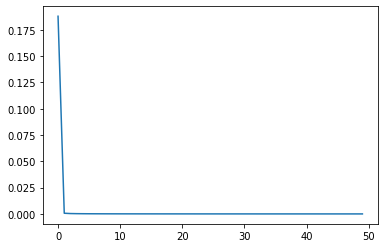

In [ ]:
plt.plot(all_losses)

In [ ]:
compute_accuracy(my_cnn, val_images_4, val_labels_4, W, B)

1.0

In [ ]:
show_accuracies(my_cnn, images_4, labels_4, val_images_4, val_labels_4, test_images_4, test_labels_4, W, B)

Accuracies :
    - train accuracy = 100.0 %
    - val accuracy = 100.0 %
    - test accuracy = 100.0 %


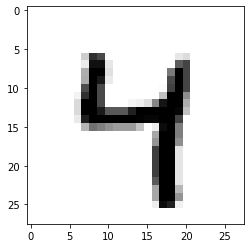

In [ ]:
indices = []
for i in range(len(val_labels)):
    if val_labels[i] == 4:
        indices.append(i)

val_labels_4 = val_labels[indices]
val_images_4 = val_images[indices]
show_multiple_images(val_images_4, 10)

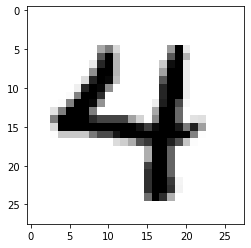

In [ ]:
indices = []
for i in range(len(test_labels)):
    if test_labels[i] == 4:
        indices.append(i)

test_labels_4 = test_labels[indices]
test_images_4 = test_images[indices]
show_multiple_images(test_images_4, 10)

In [ ]:
np.log(np.exp(np.array([700, 0, 1, 725, 750, 15])) * (-1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


array([nan, nan, nan, nan, nan, nan])

In [ ]:
dd = [None, None]
if type(dd) != type(None):
    print('hello')


hello


In [ ]:
[{'height_image': 28,
  'nbr_channels': 1,
  'type_of_layer': 'input',
  'width_image': 28},
 {'kernel_size': 5,
  'nbr_of_kernels': 6,
  'padding': 0,
  'stride': 1,
  'type_of_activation': 'relu',
  'type_of_layer': 'convolution'},
 {'kernel_size': 5,
  'stride': 2,
  'type_of_layer': 'pooling',
  'type_of_pooling': 'MAX_POOLING'},
 {'type_of_layer': 'flatten'},
 {'learning_rate': 0.01,
  'nbr_of_neurons': 20,
  'type_of_activation': 'tanh',
  'type_of_layer': 'fcl'},
 {'learning_rate': 0.01,
  'nbr_of_neurons': 10,
  'type_of_activation': 'softmax',
  'type_of_layer': 'fcl'}]

In [ ]:
# forward pass for 1000 images costs 137 seconds

In [ ]:
fi = [1, 2, 5]
fi = fi[::-1]
for i in fi:
    print(i)